# Hierarchy-aware model-based selection Goals
- V/A prediction
- category-aware top-k selection
- per-base vs averaged comparison

In [71]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')
# load utils
from src.perceptual_descriptor_selection import *
from src.make_dataset.split_data import *

## Data & hierarchy

In [73]:
# Load the full features
X_raw = pd.read_parquet("../data/processed/features_decorrelated_2080.parquet")
X_raw.index = X_raw.index.astype(int)

labels = pd.read_parquet("../data/processed/core_dataset.parquet")
labels = labels.set_index("song_id")
labels.index = labels.index.astype(int)

# align features and labels
common_ids = X_raw.index.intersection(labels.index)

X = X_raw.loc[common_ids] # apply the alignment
y_valence = labels.loc[common_ids, "valence_mean"].rename("valence")
y_arousal = labels.loc[common_ids, "arousal_mean"].rename("arousal")
y_valence_std = labels.loc[common_ids, "valence_std"]
y_arousal_std = labels.loc[common_ids, "arousal_std"]

print(X.shape, y_valence.shape, y_arousal.shape)

(1802, 1257) (1802,) (1802,)


In [74]:
# Load the hierarchy map
hierarchy_map_path = Path("../data/hierarchy_map.csv")

hierarchy_map_full = pd.read_csv(hierarchy_map_path)
print(hierarchy_map_full.head())

                      feature          perceptual   musical
0           F0final_sma_amean       melodiousness     pitch
1        F0final_sma_de_amean       melodiousness     pitch
2       F0final_sma_de_stddev     tonal_stability     pitch
3          F0final_sma_stddev     tonal_stability     pitch
4  audSpec_Rfilt_sma[0]_amean  rhythmic_stability  spectral


In [75]:
# Show hierarchy summary
print(f"\nHierarchy summary:")
perceptual_counts = hierarchy_map_full['perceptual'].value_counts()
print(f"Perceptual-level categories ({len(perceptual_counts)}):")
for category, count in perceptual_counts.items():
    print(f"  {category}: {count} base features")


Hierarchy summary:
Perceptual-level categories (7):
  articulation: 60 base features
  tonal_stability: 52 base features
  dissonance: 48 base features
  rhythmic_complexity: 34 base features
  unmapped: 32 base features
  rhythmic_stability: 18 base features
  melodiousness: 16 base features


In [77]:
from src.utils import base_of, desc_of
# drop unmapped features (fully interpretable model)
VALID_CATS = ["melodiousness","articulation","rhythmic_stability",
              "rhythmic_complexity","dissonance","tonal_stability"]
hierarchy_map = hierarchy_map_full.query("perceptual in @VALID_CATS").copy()
mapped_bases  = set(hierarchy_map["feature"])
X = X[[c for c in X.columns if base_of(c) in mapped_bases]].copy() # drop unmapped

In [78]:
assert {"feature","perceptual"}.issubset(hierarchy_map.columns)
n_bases_in_X = len({base_of(c) for c in X.columns})
n_bases_mapped = len({base_of(c) for c in X.columns} & set(hierarchy_map["feature"]))
print(f"Mapped bases: {n_bases_mapped}/{n_bases_in_X}")

Mapped bases: 202/202


### Config:
- load saved cross-validation folds and custom and original splits
- check univariate statistics for feature importance (spearman chosen for)

In [81]:
X.shape

(1802, 1001)

In [82]:
# cv splits
cv5_splits = load_kfold_splits()
# custom splits
tr, val, test = load_splits_triplet()
# original splits
tr_orig, val_orig, test_orig = load_splits_triplet(name='original')
# dev ids for final model
dev_ids = tr.union(val)

In [83]:
len(tr), len(tr_orig), len(dev_ids)

(1257, 1488, 1533)

In [84]:
# per-category relevance of each descriptor (median |Spearman| across bases)
def relevance_table(X, y, hierarchy_map):
    descs = sorted({desc_of(c) for c in X.columns if '_' in c})
    cats  = sorted(hierarchy_map['perceptual'].unique())
    rows = []
    for cat in cats:
        bases = hierarchy_map[hierarchy_map['perceptual']==cat]['feature'].tolist()
        for d in descs:
            cors = []
            for b in bases:
                col = f"{b}_{d}"
                if col in X.columns:
                    s = X[col]
                    m = s.notna() & y.notna()
                    if m.sum() >= 10:
                        cors.append(abs(s[m].corr(y[m], method='spearman')))
            rows.append((cat, d, np.median(cors) if cors else np.nan))
    return (pd.DataFrame(rows, columns=['cat','desc','med_abs_spearman'])
              .pivot(index='cat', columns='desc', values='med_abs_spearman'))

tbl = relevance_table(X, y_valence, hierarchy_map)
print(tbl.rank(axis=1, ascending=False).astype(int))  # see how often q25 ranks #1

desc                 kurtosis  max  mean  min  q25  q75  skew  std
cat                                                               
articulation                5    8     4    2    1    3     7    6
dissonance                  7    6     5    4    1    2     8    3
melodiousness               7    8     6    2    1    3     5    4
rhythmic_complexity         6    7     2    1    3    4     5    8
rhythmic_stability          3    8     5    2    1    4     6    7
tonal_stability             8    4     3    1    2    5     7    6


q25 descriptor still dominates, but this time not completely, decorrelation seems to have helped by removing multiple features that were carrying the same strong signal, and now other features can share some importance, mixing it up

In [85]:
from importlib import reload
from src import perceptual_descriptor_selection
from src.make_dataset import split_data
from src import utils

reload(utils)

reload(perceptual_descriptor_selection)
reload(split_data)

<module 'src.make_dataset.split_data' from '/home/georgios/PGMP/notebooks/../src/make_dataset/split_data.py'>

### Part 1: Rankings cache per fold (joint V+A)

In [86]:
# Precompute joint rankings for each fold
from src.perceptual_descriptor_selection import compute_descriptor_ranking_joint_shap

rankings_per_fold = {}

for fold_id, (tr, va) in enumerate(cv5_splits):
    print(f"Fold {fold_id}: train={len(tr)}, val={len(va)}")
    tr_idx = X.index.intersection(tr)
    
    rankings_per_fold[fold_id] = compute_descriptor_ranking_joint_shap(
        X, y_valence, y_arousal, hierarchy_map,
        train_index=tr_idx,
        n_estimators=100, sample_n=600, random_state=42
    )

Fold 0: train=1231, val=302
Fold 1: train=1209, val=324
Fold 2: train=1206, val=327
Fold 3: train=1267, val=266
Fold 4: train=1219, val=314


In [87]:
# cache the ranks to disk
import joblib

joblib.dump(rankings_per_fold, "temp/2080_decorr/rankings_per_fold_L1.pkl")

['temp/2080_decorr/rankings_per_fold_L1.pkl']

In [88]:
rankings_per_fold = joblib.load("temp/2080_decorr/rankings_per_fold_L1.pkl")

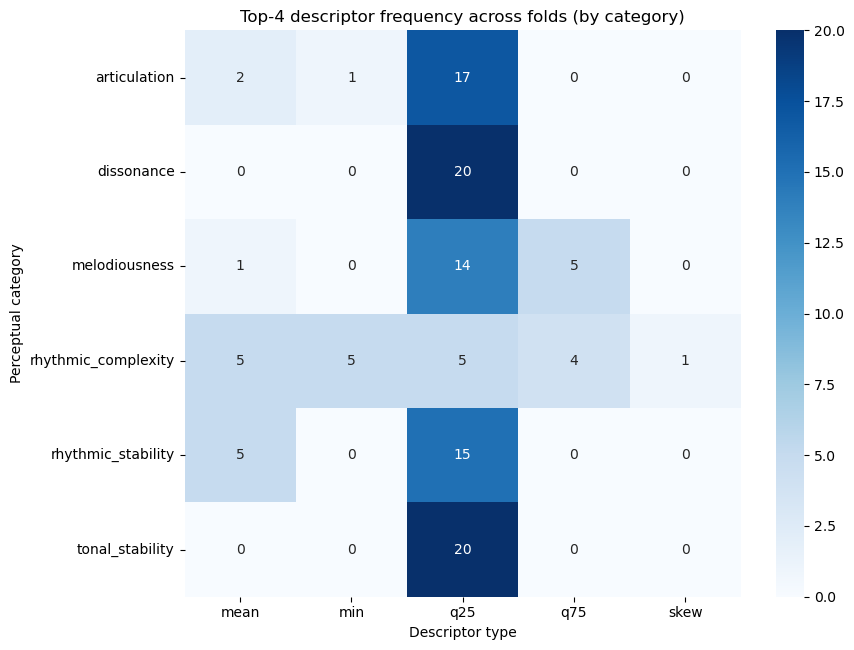

In [89]:
cats = sorted(hierarchy_map['perceptual'].unique())
folds = sorted(rankings_per_fold.keys())

# Count how often each descriptor type appears in top-2
freq = {}
for c in cats:
    desc_types = []
    for f in folds:
        # Get top-4 column names and extract their descriptor types
        top_cols = rankings_per_fold[f].get(c, pd.Series(dtype=float)).index[:4]
        desc_types.extend([desc_of(col) for col in top_cols])
    freq[c] = pd.Series(desc_types).value_counts()

# Build matrix
all_descs = sorted({d for c in cats for d in freq[c].index})
F = pd.DataFrame(0, index=cats, columns=all_descs)
for c in cats:
    F.loc[c, freq[c].index] = freq[c].values

plt.figure(figsize=(min(10, 1.0*len(all_descs)+4), 0.6*len(cats)+3))
sns.heatmap(F, cmap="Blues", annot=True, fmt="g")
plt.title("Top-4 descriptor frequency across folds (by category)")
plt.xlabel("Descriptor type")
plt.ylabel("Perceptual category")
plt.tight_layout()
plt.savefig("temp/2080_decorr/top4_with_L1.png", dpi=300, bbox_inches="tight")
plt.show()

Every LLDs strongest signal resides in q25. After that, for melodiousness and articulation q75 is also strong signal, and mean is a strong signal for rhythmic stability

### Part 2: Evaluating k-rankings and per-base vs averaged

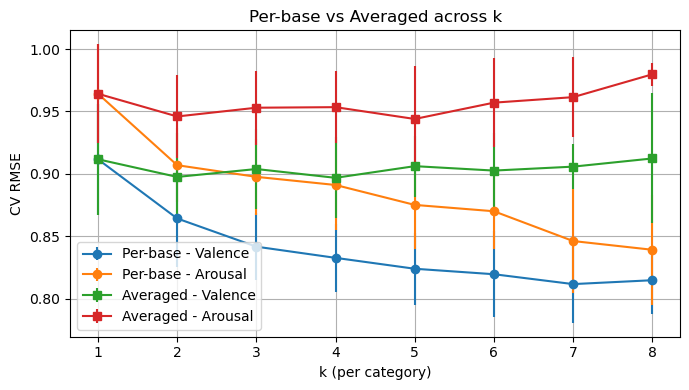

In [90]:
# k-sweep using rank-and-slice (per_base vs averaged)
from src.perceptual_descriptor_selection import cv_rmse_across_k_nested_joint_ranked
from src.utils import pick_best_k

df_joint_per_base = cv_rmse_across_k_nested_joint_ranked(
    X, y_valence, y_arousal, hierarchy_map,
    splits=cv5_splits, rankings_per_fold=rankings_per_fold,
    ks=range(1,9), aggregation_mode='per_base'
)

df_joint_avg = cv_rmse_across_k_nested_joint_ranked(
    X, y_valence, y_arousal, hierarchy_map,
    splits=cv5_splits, rankings_per_fold=rankings_per_fold,
    ks=range(1,9), aggregation_mode='perceptual'
)

fig, ax = plt.subplots(figsize=(7,4))
ax.errorbar(df_joint_per_base.k, df_joint_per_base.rmse_val_mean, yerr=df_joint_per_base.rmse_val_std, fmt='-o', label='Per-base - Valence')
ax.errorbar(df_joint_per_base.k, df_joint_per_base.rmse_aro_mean, yerr=df_joint_per_base.rmse_aro_std, fmt='-o', label='Per-base - Arousal')
ax.errorbar(df_joint_avg.k,      df_joint_avg.rmse_val_mean,      yerr=df_joint_avg.rmse_val_std,      fmt='-s', label='Averaged - Valence')
ax.errorbar(df_joint_avg.k,      df_joint_avg.rmse_aro_mean,      yerr=df_joint_avg.rmse_aro_std,      fmt='-s', label='Averaged - Arousal')
ax.grid(True); ax.set_xlabel("k (per category)"); ax.set_ylabel("CV RMSE"); ax.set_title("Per-base vs Averaged across k")
ax.legend(); plt.tight_layout()
plt.show()

In [91]:
# hybrid sweep: re-rank for k<8, cache for k=8
ks = range(1, 9)
rows = []
print('Evaluating k estimation with cached ranks, and with re-ranking across k')
for k in ks:
    print(f' k = {k}')
    if k < 8:
        df_k = cv_rmse_across_k_nested_joint(
            X, y_valence, y_arousal, hierarchy_map,
            splits=cv5_splits, ks=[k], aggregation_mode='per_base',
            n_estimators=100, sample_n=800
        )
    else:
        df_k = cv_rmse_across_k_nested_joint_ranked(
            X, y_valence, y_arousal, hierarchy_map,
            splits=cv5_splits, rankings_per_fold=rankings_per_fold,
            ks=[k], aggregation_mode='per_base', n_estimators=100
        )
    rows.append(df_k)

Evaluating k estimation with cached ranks, and with re-ranking across k
 k = 1
 k = 2
 k = 3
 k = 4
 k = 5
 k = 6
 k = 7
 k = 8


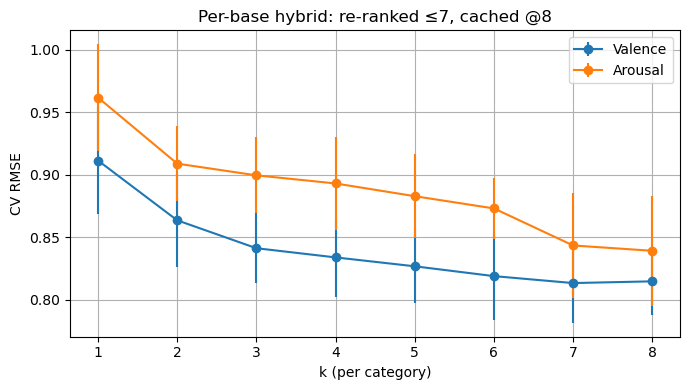

In [92]:
df_best_k = pd.concat(rows, ignore_index=True)
fig, ax = plt.subplots(figsize=(7,4))
ax.errorbar(df_best_k.k, df_best_k.rmse_val_mean,
            yerr=df_best_k.rmse_val_std, fmt='-o', label='Valence')
ax.errorbar(df_best_k.k, df_best_k.rmse_aro_mean,
            yerr=df_best_k.rmse_aro_std, fmt='-o', label='Arousal')
ax.grid(True); ax.set_xlabel("k (per category)"); ax.set_ylabel("CV RMSE")
ax.set_title("Per-base hybrid: re-ranked ≤7, cached @8")
ax.legend(); plt.tight_layout(); plt.show()

No observable difference from re-ranking, ranks remain the same across k values

In [93]:
# choose best k, from the full cv version with re-ranking
best_k = pick_best_k(df_best_k)
print("Chosen k =", best_k)

Chosen k = 8


In [94]:
print(int(df_best_k.loc[df_best_k.rmse_mean.idxmin(), "k"]))

8


In [14]:
#0.8257

### Part 3: Weighting experiment 

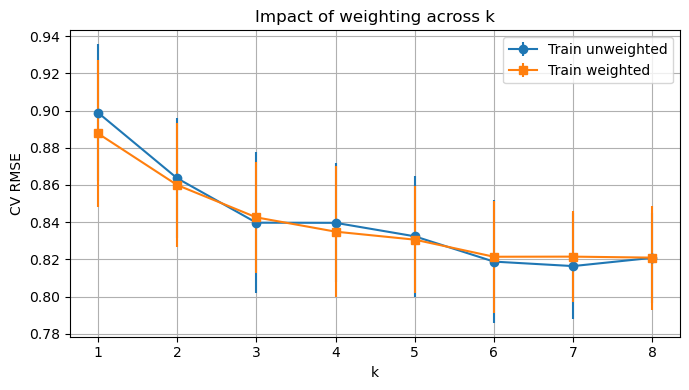

In [95]:
# Build per-base features with chosen k using union of all train ids for selection stability
# with effect-of-weighting curve - not using cached importance, selection adapts with weights
from src.perceptual_descriptor_selection import k_sweep_weighting_compare_nested

df_unweighted, df_weighted = k_sweep_weighting_compare_nested(
    X, y_valence, hierarchy_map, cv5_splits, labels, std_col='valence_std',
    ks=range(1,9), use_marginal=True # keeps leak-safe per-fold selection
)
plot_weighting_k_curves(df_unweighted, df_weighted)

### Part 4: Final model + SHAP with grouped summaries

In [96]:
from src.perceptual_descriptor_selection import select_top_k_descriptors_joint_shap, build_per_base_X

sel_final = select_top_k_descriptors_joint_shap(
    X, y_valence, y_arousal, hierarchy_map, k=best_k,
    train_index=dev_ids, n_estimators=200, sample_n=800 #only pass the development ids
)
X_final = build_per_base_X(X, hierarchy_map, sel_final)

In [97]:
# Leak-free impute with DEV medians
med_dev = X_final.loc[dev_ids].median(numeric_only=True)
print("NaNs before imputing (DEV/TEST):", X_final.loc[dev_ids].isna().sum().sum(),
      X_final.loc[test].isna().sum().sum())
X_dev = X_final.loc[dev_ids].fillna(med_dev)
X_test  = X_final.loc[test].fillna(med_dev)

y_dev = y_valence.loc[X_dev.index]
y_test  = y_valence.loc[X_test.index]

NaNs before imputing (DEV/TEST): 0 0


In [98]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

In [99]:
# Train final RF (unweighted, to mirror real-world scenarios where no annotator std is available)
final_model = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                    min_samples_leaf=2, random_state=42, n_jobs=-1)
final_model.fit(X_dev, y_dev.loc[X_dev.index])

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [100]:
p_dev = final_model.predict(X_dev)
p_test  = final_model.predict(X_test)

print(f"Per-base DEV RMSE: {rmse(y_dev, p_dev):.4f}")
print(f"Per-base TEST RMSE: {rmse(y_test, p_test):.4f}")

Per-base DEV RMSE: 0.3541
Per-base TEST RMSE: 0.9670


In [101]:
# SHAP aggregated by perceptual to visualize the feature importance in the mid-level
sample_X = X_final.sample(min(800, len(X_final)), random_state=42)
explainer = shap.TreeExplainer(final_model,feature_perturbation="tree_path_dependent")
sv = explainer.shap_values(sample_X)

In [102]:
from src.perceptual_descriptor_selection import shap_summary_for_k
# averaged (baseline)
rf_avg, X_avg, shap_avg, order_avg, exp_avg, _ = shap_summary_for_k(
    X, y_valence, hierarchy_map, k=best_k, mode="perceptual"
)

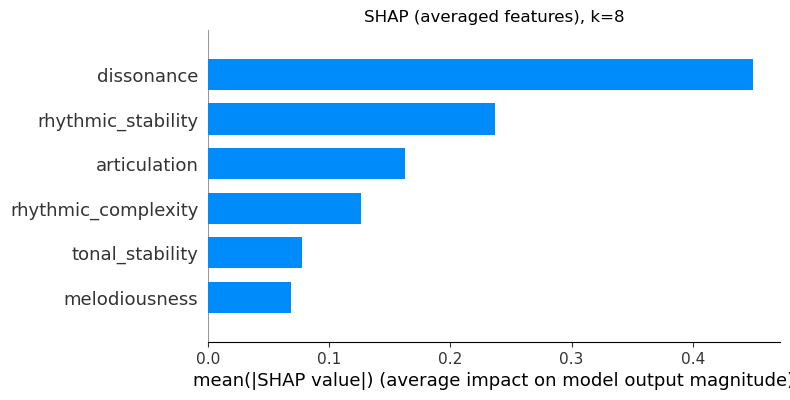

In [103]:
bg = X_avg.sample(min(800, len(X_avg)), random_state=42)
sv = exp_avg.shap_values(bg, check_additivity=False)
shap.summary_plot(exp_avg.shap_values(X_avg), X_avg, plot_type="bar", show=False)
plt.title(f"SHAP (averaged features), k={best_k}"); plt.show()

As shown above, the baseline model using simple averaging is heavily dominated by the 'dissonance' and 'rhythmic_complexity' feature. This masks the contribution of other important musical cues that can be leveraged with the granular per-base approach

In [104]:
# per-base design
sample_X = X_final.sample(min(800, len(X_final)), random_state=42)
exp_per  = shap.TreeExplainer(final_model, feature_perturbation="tree_path_dependent")
sv_per   = exp_per.shap_values(sample_X, check_additivity=False)

In [105]:
from src.perceptual_descriptor_selection import aggregate_shap_for_summary
# run the grouped aggregated(grouped version)
shap_grouped, X_grouped, group_names = aggregate_shap_for_summary(
    sv_per, sample_X, hierarchy_map, level='perceptual'
)

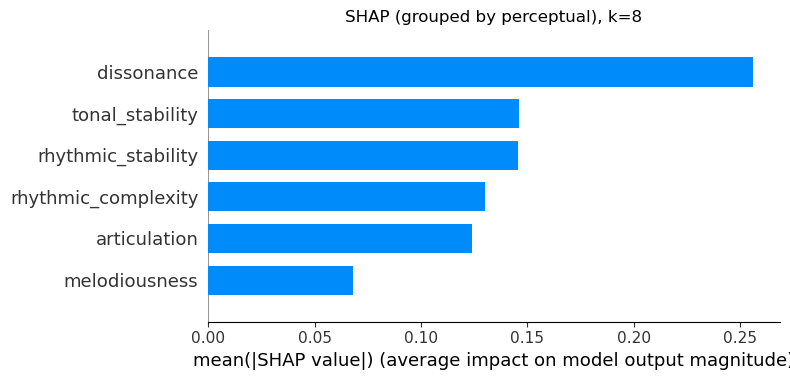

In [106]:
X_grouped_df = pd.DataFrame(X_grouped, index=sample_X.index, columns=group_names)
shap.summary_plot(shap_grouped,X_grouped_df,plot_type="bar",max_display=7, show=False)
plt.title(f"SHAP (grouped by perceptual), k={best_k}")
plt.tight_layout()
plt.show()

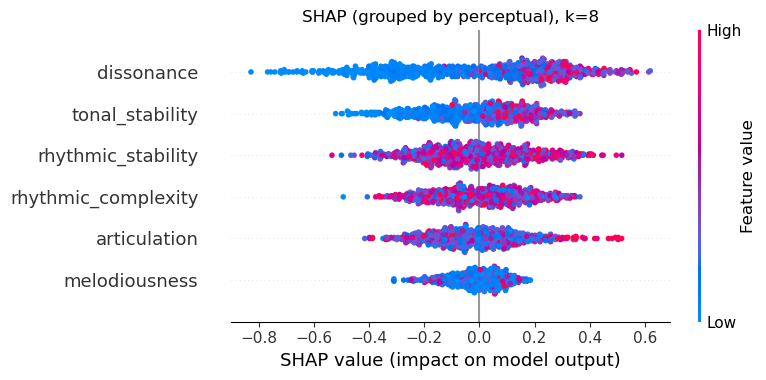

In [107]:
shap.summary_plot(shap_grouped, X_grouped, feature_names=group_names, show=False)
plt.title(f"SHAP (grouped by perceptual), k={best_k}"); plt.tight_layout(); plt.show()

This plot reveals how different feature values impact valence predictions:
- Red/blue dots show high/low feature values
- Position on x-axis shows impact on model output
- Features are ordered by overall importance
- The spread shows how consistently each feature contributes

Insights (susceptible to the quality of the mapping, not reliable):
- High values of dissonance -> high valence (this is probably a mapping error, cause timbre-like features got placed in the class 'dissonance', perhaps consonance would have been a better reflection of the mapping, or dataset bias (e.g., bright pop mixes tagged higher valence))
- High values of rhythmic stability -> high valence (that one checks out, and stability was mapped with _mean features (static), so a high overall tempo might correlate with high valence, LLDs that were mapped -RMSenergy, loudness, audspec_lengthL1norm, audspecRasta_lengthL1norm, audSpec_Rfilt[0-5])
- Low values of articulation -> Low Valence (maybe many tracks with legato?, probably also mapping instability)

In [108]:
# check for music level
from src.perceptual_descriptor_selection import aggregate_shap_for_summary
shap_grouped, X_grouped, group_names = aggregate_shap_for_summary(
    sv_per, sample_X, hierarchy_map, level='musical'
)

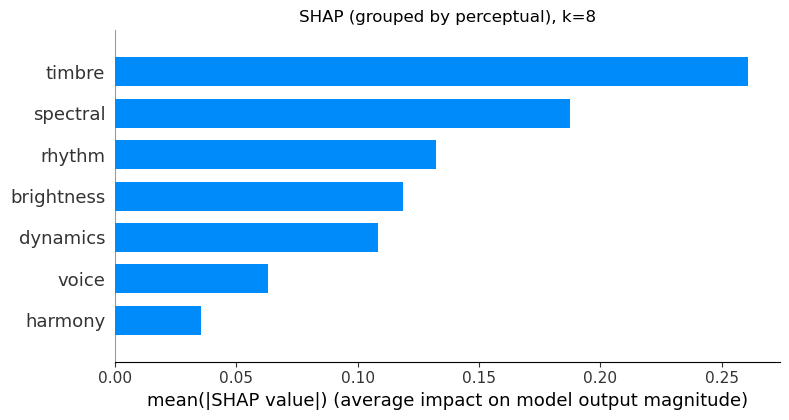

In [109]:
X_grouped_df = pd.DataFrame(X_grouped, index=sample_X.index, columns=group_names)
shap.summary_plot(shap_grouped,X_grouped_df,plot_type="bar",max_display=7, show=False)
plt.title(f"SHAP (grouped by perceptual), k={best_k}")
plt.tight_layout()
plt.show()

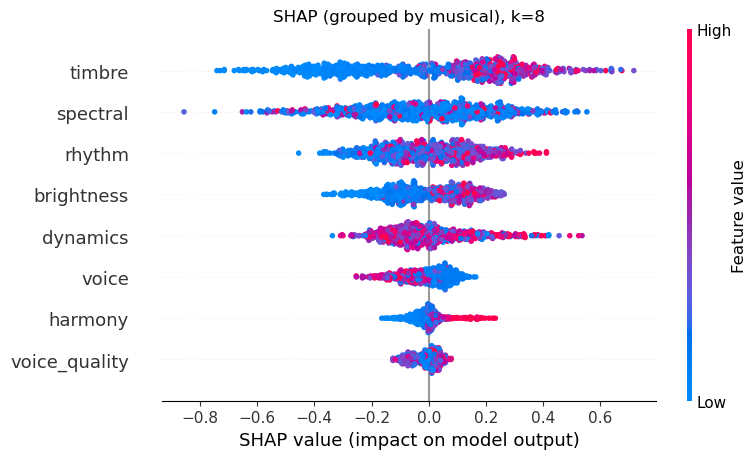

In [110]:
shap.summary_plot(shap_grouped, X_grouped, feature_names=group_names, show=False)
plt.title(f"SHAP (grouped by musical), k={best_k}"); plt.tight_layout(); plt.show()

Insights (seems like this offers more reasonable reads):
- High values of timbre -> high valence (this is logical, higher pitches usually correlate with more happiness, and vice-versa with low bass-like timbre usually music has more negative emotion (e.g. heavy rock, dramatic low octave piano notes))
- High values of dynamics -> high valence (more energetic songs tend to be more fun/happy than slow ones with low dynamics)
- High values of voice quality -> Low Valence (that one doesn't appear logical, problem lies either with the mapping or the model)
- High harmony -> high valence (checks out)

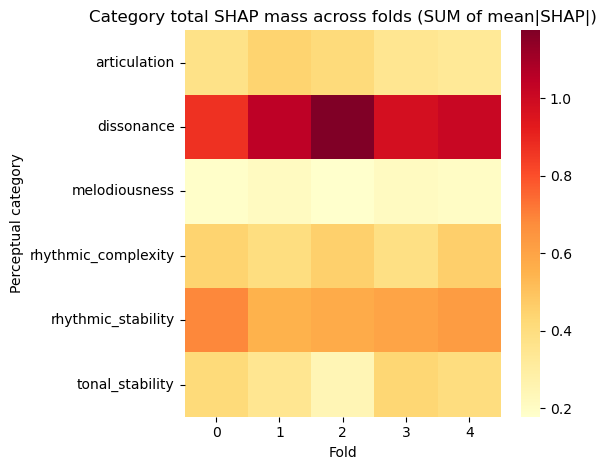

In [111]:
from src.utils import category_mass_from_model, plot_category_mass_heatmap
# plot the stability of category importance across different data splits
category_sums_per_fold = {}

for fold_id, (tr_ids, va_ids) in enumerate(cv5_splits):
    # build selection for this fold (use cached rankings)
    sel = selections_from_rank(rankings_per_fold[fold_id], k=best_k)

    # build the design used to train the models for this fold
    X_all = build_per_base_X(X, hierarchy_map, sel)
    tr = X_all.index.intersection(tr_ids)
    med = X_all.loc[tr].median(numeric_only=True)
    Xtr = X_all.loc[tr].fillna(med)

    # fit fold-specific models
    rf_v = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    rf_a = RandomForestRegressor(n_estimators=200, random_state=43, n_jobs=-1)
    rf_v.fit(Xtr, y_valence.loc[tr])
    rf_a.fit(Xtr, y_arousal.loc[tr])

    assert hasattr(rf_v, "estimators_") and len(rf_v.estimators_) > 0
    assert hasattr(rf_a, "estimators_") and len(rf_a.estimators_) > 0

    # SHAP mass per category on train for this fold
    cat_v = category_mass_from_model(rf_v, Xtr, hierarchy_map, level="perceptual", seed=42)
    cat_a = category_mass_from_model(rf_a, Xtr, hierarchy_map, level="perceptual", seed=43)
    category_sums_per_fold[fold_id] = cat_v.add(cat_a, fill_value=0.0)

plot_category_mass_heatmap(
    category_sums_per_fold,
    zscore_within_fold=False,
    title="Category total SHAP mass across folds (SUM of mean|SHAP|)"
)

### Save optimal configuration

In [25]:
import json

optimal_config = {
    'best_k': int(best_k),
    'method': 'RF',
    'final_model': {'estimator': 'RandomForestRegressor', 'n_estimators': 400, 'random_state': 42},
    'selections': {k: list(map(str, v)) for k, v in sel_final.items()}
}

with open('../results/experiments/exp3_decorr_2080/optimal_descriptor_config.json', 'w') as f:
    json.dump(optimal_config, f, indent=2)


Optimal configuration saved to 'optimal_descriptor_config.json'


# Visualise final category selections

In [112]:
from src import perceptual_descriptor_selection
from src import viz
reload(perceptual_descriptor_selection)
reload(viz)

<module 'src.viz' from '/home/georgios/PGMP/notebooks/../src/viz.py'>

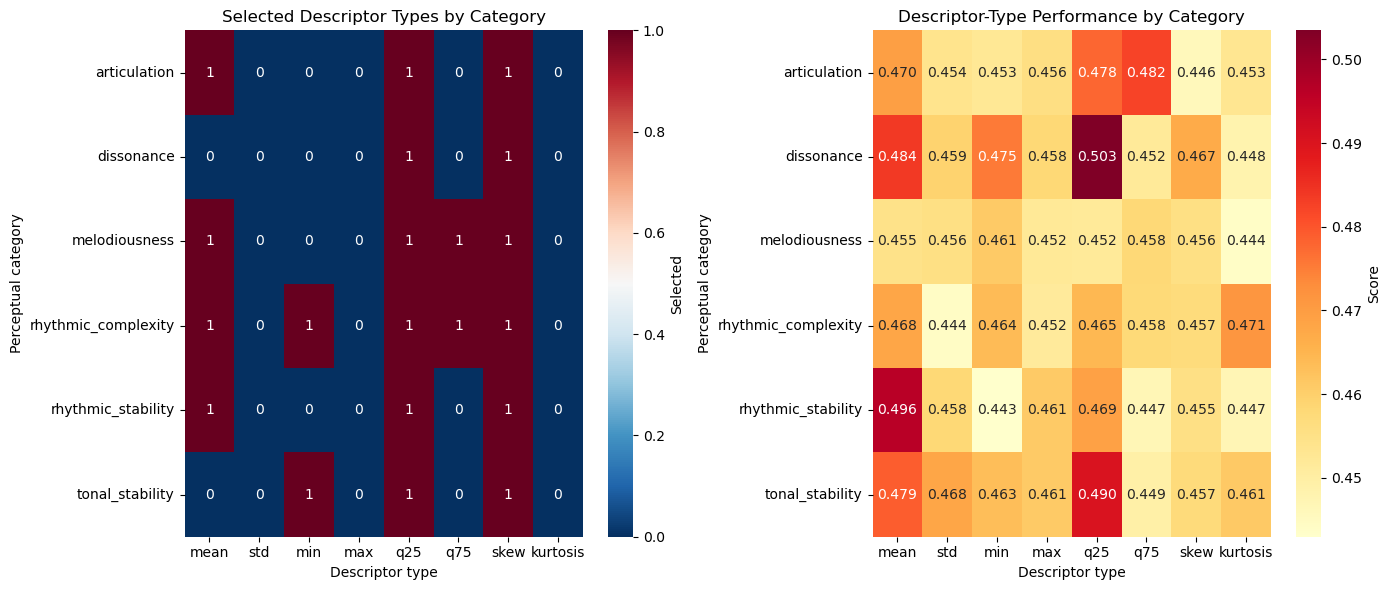

In [114]:
from src.viz import visualize_category_selections

# Show what descriptors were selected for each category
selection_matrix, performance_matrix = visualize_category_selections(sel_final, X, y_valence,
                                                                     hierarchy_map)

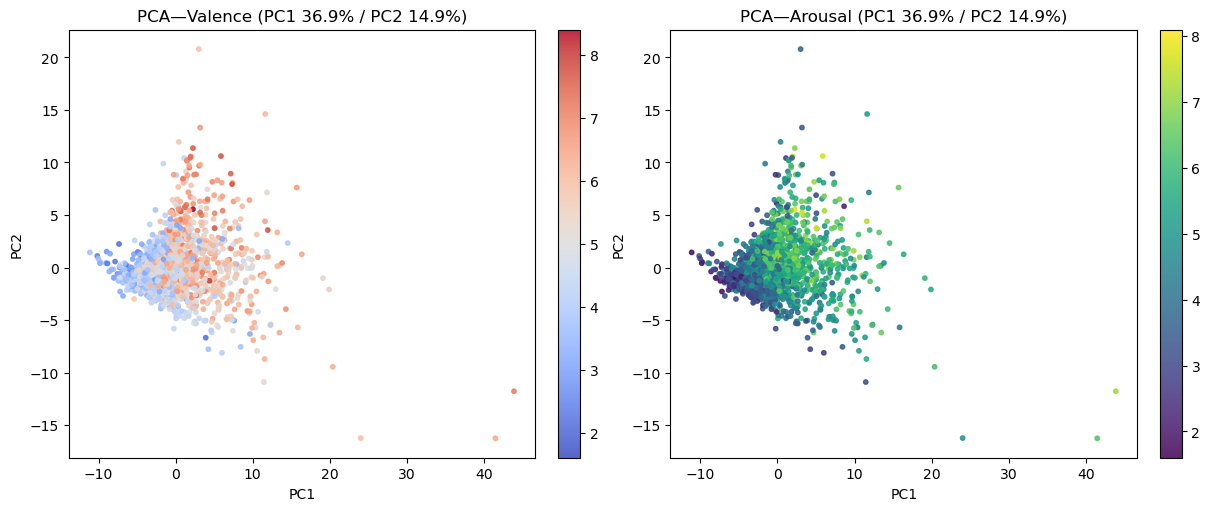

In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

idx = X_final.index.intersection(y_valence.index).intersection(y_arousal.index)
Z = StandardScaler().fit_transform(X_final.loc[idx].fillna(X_final.loc[idx].median()))
p = PCA(n_components=2, random_state=42).fit(Z)
PC = p.transform(Z); v1,v2 = p.explained_variance_ratio_*100

va = y_valence.loc[idx].astype(float).values
ar = y_arousal.loc[idx].astype(float).values

fig, ax = plt.subplots(1,2,figsize=(12,5), constrained_layout=True)
s=ax[0].scatter(PC[:,0],PC[:,1],c=va,s=10,cmap='coolwarm',alpha=.85)
ax[0].set(title=f"PCA—Valence (PC1 {v1:.1f}% / PC2 {v2:.1f}%)",xlabel='PC1',ylabel='PC2'); fig.colorbar(s,ax=ax[0])
s=ax[1].scatter(PC[:,0],PC[:,1],c=ar,s=10,cmap='viridis',alpha=.85)
ax[1].set(title=f"PCA—Arousal (PC1 {v1:.1f}% / PC2 {v2:.1f}%)",xlabel='PC1',ylabel='PC2'); fig.colorbar(s,ax=ax[1])
plt.show()

In [116]:
# Fit PCA on the selected per-base features
Xf = X_final.fillna(X_final.median())
Z  = StandardScaler().fit_transform(Xf)
pca = PCA(n_components=2, random_state=42).fit(Z)

scores   = pd.DataFrame(pca.transform(Z), index=Xf.index, columns=['PC1','PC2'])
loadings = pd.DataFrame(pca.components_.T, index=Xf.columns, columns=['PC1','PC2'])
expl_var = pca.explained_variance_ratio_
print(f"Explained variance: PC1={expl_var[0]:.2%}, PC2={expl_var[1]:.2%}")

# How PCs relate to Valence/Arousal (Spearman = robust)
corrs = scores.assign(valence=y_valence.loc[scores.index],
                      arousal=y_arousal.loc[scores.index]) \
              .corr(method='spearman').loc[['PC1','PC2'], ['valence','arousal']]
print(corrs)

Explained variance: PC1=36.94%, PC2=14.90%
      valence   arousal
PC1  0.609692  0.605158
PC2  0.252430  0.369004


## Add minorness from mode metadata, Create the mid and high-level features

In [117]:
# Build minorness score (0..1), index by song_id
mode_df = pd.read_parquet("../data/processed/audio_metadata.parquet")
m = mode_df[['song_id','mode','key_confidence']].copy()
m['is_minor'] = (m['mode'].str.lower() == 'minor').astype(int)
m['minorness'] = (m['is_minor'] * m['key_confidence']).astype(float)
m = m.set_index('song_id').reindex(X_final.index)

In [118]:
from importlib import reload
from src import derived

reload(derived)

<module 'src.derived' from '/home/georgios/PGMP/notebooks/../src/derived.py'>

In [119]:
from src.derived import create_perceptual_features
# Create mid-level features from the selected per-base features
perceptual_level_df = create_perceptual_features(X_final, hierarchy_map)
# append minorness for analysis (does not affect training/selection)
perceptual_level_df = perceptual_level_df.join(m[['minorness']], how='left')
print(f"Perceptual-level features shape: {perceptual_level_df.shape}")
print(f"Perceptual-level features: {perceptual_level_df.columns.tolist()}")

Perceptual-level features shape: (1802, 7)
Perceptual-level features: ['articulation', 'dissonance', 'melodiousness', 'rhythmic_complexity', 'rhythmic_stability', 'tonal_stability', 'minorness']


In [120]:
perceptual_level_df.head(1)

,articulation,dissonance,melodiousness,rhythmic_complexity,rhythmic_stability,tonal_stability,minorness
song_id,,,,,,,
2,0.357464,63398.703654,2.628658,0.042221,0.504072,36.592001,0.259305


In [121]:
# Create high-level features
from src.derived import create_musical_features
musical_level_df = create_musical_features(X_final, hierarchy_map)
musical_level_df = musical_level_df.join(m[['minorness']], how='left')
print(f"Musical-level features shape: {musical_level_df.shape}")
print(f"Musical-level features: {musical_level_df.columns.tolist()}")

Musical-level features shape: (1802, 9)
Musical-level features: ['timbre', 'rhythm', 'brightness', 'spectral', 'harmony', 'voice_quality', 'voice', 'dynamics', 'minorness']


In [122]:
# test minorness signal - fit a rf on the features first without it, then add it and check the delta
Xb = X_final.copy()

# per-base design + minorness version
Xm = Xb.join(m[['minorness']].rename(columns={'minorness':'meta_minorness'}), how='left')
med = Xm.loc[dev_ids].median(numeric_only=True); Xm = Xm.fillna(med)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

rmse_base = []
rmse_minor = []
for tr, va in cv5_splits:
    tr = Xb.index.intersection(tr); va = Xb.index.intersection(va)
    # base
    rf.fit(Xb.loc[tr], y_valence.loc[tr])
    p = rf.predict(Xb.loc[va])
    rmse_base.append(np.sqrt(((y_valence.loc[va]-p)**2).mean()))
    # +minorness
    rf.fit(Xm.loc[tr], y_valence.loc[tr])
    p = rf.predict(Xm.loc[va])
    rmse_minor.append(np.sqrt(((y_valence.loc[va]-p)**2).mean()))

print(f"ΔRMSE (valence): {np.mean(rmse_base)-np.mean(rmse_minor):.4f} (positive = minorness helps)")

ΔRMSE (valence): 0.0041 (positive = minorness helps)


signal from minorness is extremely weak, not aligning with studies. Perhaps an artifact of the method used to collect it (madmom extracted mode, gave back only major or minor, converted to 0/1 and multiplied by key_confidence), or the specific dataset.

# Train/val/test split

In [123]:
train_ids_custom, val_ids_custom, test_ids_custom = load_splits_triplet()

In [124]:
train_ids, val_ids, test_ids = load_splits_triplet(out_dir="../data/splits", name = 'original')

# Normalize features

In [125]:
from src.normalization import SplitScaler

# Split the data
X_train_orig = X_final.loc[train_ids]
X_val_orig = X_final.loc[val_ids]
X_test_orig = X_final.loc[test_ids]

In [126]:
# Normalize
scaler = SplitScaler()
X_train_scaled_orig = scaler.fit_transform(X_train_orig)
X_val_scaled_orig = scaler.transform(X_val_orig)
X_test_scaled_orig = scaler.transform(X_test_orig)

print(f"Train: {X_train_scaled_orig.shape}")
print(f"Val: {X_val_scaled_orig.shape}")
print(f"Test: {X_test_scaled_orig.shape}")

Train: (1488, 48)
Val: (256, 48)
Test: (58, 48)


In [127]:
X_train_custom = X_final.loc[train_ids_custom]
X_val_custom = X_final.loc[val_ids_custom]
X_test_custom = X_final.loc[test_ids_custom]
# Normalize
scaler = SplitScaler()
X_train_scaled_custom = scaler.fit_transform(X_train_custom)
X_val_scaled_custom = scaler.transform(X_val_custom)
X_test_scaled_custom = scaler.transform(X_test_custom)
print(f"Train: {X_train_scaled_custom.shape}")
print(f"Val: {X_val_scaled_custom.shape}")
print(f"Test: {X_test_scaled_custom.shape}")

Train: (1257, 48)
Val: (276, 48)
Test: (269, 48)


Note: Normalization at this stage after having already used the unscaled features throughout is fine. The reason is because the methods that were used to find optimal k descriptors per each low-level feature were scale agnostic (rf), but future distance based methods (like KNN) will require a more scaled feature space

# Save everything

In [128]:
import joblib

output_dir = Path("../data/processed/derived/exp3_decorrelated_2080")
output_dir.mkdir(exist_ok=True)

# Save feature sets at different levels
X_final.to_parquet(output_dir / "low_level_selected.parquet")
perceptual_level_df.to_parquet(output_dir / "perceptual_level.parquet")
musical_level_df.to_parquet(output_dir / "musical_level.parquet")

In [129]:
output_dir_orig = Path(output_dir / "orig_split/")
output_dir_custom = Path(output_dir / "custom_split/")
output_dir_orig.mkdir(exist_ok=True)
output_dir_custom.mkdir(exist_ok=True)
# Save splits
X_train_scaled_orig.to_parquet(output_dir_orig / "X_train_scaled_orig.parquet")
X_val_scaled_orig.to_parquet(output_dir_orig / "X_val_scaled_orig.parquet")
X_test_scaled_orig.to_parquet(output_dir_orig / "X_test_scaled_orig.parquet")

X_train_scaled_custom.to_parquet(output_dir_custom / "X_train_scaled_custom.parquet")
X_val_scaled_custom.to_parquet(output_dir_custom / "X_val_scaled_custom.parquet")
X_test_scaled_custom.to_parquet(output_dir_custom / "X_test_scaled_custom.parquet")

# Save targets
y_valence.loc[train_ids].to_csv(output_dir_orig / "y_valence_train_orig.csv")
y_valence.loc[val_ids].to_csv(output_dir_orig / "y_valence_val_orig.csv")
y_valence.loc[test_ids].to_csv(output_dir_orig / "y_valence_test_orig.csv")

y_arousal.loc[train_ids].to_csv(output_dir_orig / "y_arousal_train_orig.csv")
y_arousal.loc[val_ids].to_csv(output_dir_orig / "y_arousal_val_orig.csv")
y_arousal.loc[test_ids].to_csv(output_dir_orig / "y_arousal_test_orig.csv")

# Save targets
y_valence.loc[train_ids_custom].to_csv(output_dir_custom / "y_valence_train_custom.csv")
y_valence.loc[val_ids_custom].to_csv(output_dir_custom / "y_valence_val_custom.csv")
y_valence.loc[test_ids_custom].to_csv(output_dir_custom / "y_valence_test_custom.csv")

y_arousal.loc[train_ids_custom].to_csv(output_dir_custom / "y_arousal_train_custom.csv")
y_arousal.loc[val_ids_custom].to_csv(output_dir_custom / "y_arousal_val_custom.csv")
y_arousal.loc[test_ids_custom].to_csv(output_dir_custom / "y_arousal_test_custom.csv")

# Save scaler and config
joblib.dump(scaler, output_dir / "scaler.pkl")

print(f"\nAll features saved to {output_dir}/")
print(f"  Low-level (selected): {X_final.shape}")
print(f"  Perceptual-level: {perceptual_level_df.shape}")
print(f"  Musical-level: {musical_level_df.shape}")


All features saved to ../data/processed/derived/exp3_decorrelated_2080/
  Low-level (selected): (1802, 48)
  Perceptual-level: (1802, 7)
  Musical-level: (1802, 9)


In [130]:
X_train_scaled_orig.head(2)

,pcm_fftMag_fband1000-4000_sma_amean_q25,pcm_zcr_sma_amean_q25,pcm_fftMag_spectralSlope_sma_stddev_q25,pcm_fftMag_spectralFlux_sma_amean_mean,audSpec_Rfilt_sma[16]_amean_q25,pcm_zcr_sma_de_amean_q25,pcm_zcr_sma_amean_mean,pcm_fftMag_spectralSlope_sma_de_stddev_skew,pcm_fftMag_spectralVariance_sma_amean_q25,pcm_fftMag_fband1000-4000_sma_stddev_q25,...,audSpec_Rfilt_sma[4]_amean_q25,audspec_lengthL1norm_sma_amean_skew,pcm_fftMag_spectralEntropy_sma_de_stddev_q25,pcm_fftMag_spectralRollOff90.0_sma_stddev_q25,pcm_fftMag_spectralHarmonicity_sma_amean_q25,audSpec_Rfilt_sma[6]_amean_q25,pcm_fftMag_spectralRollOff75.0_sma_stddev_q25,audSpec_Rfilt_sma[9]_amean_q25,voicingFinalUnclipped_sma_de_stddev_skew,voicingFinalUnclipped_sma_de_stddev_min
song_id,,,,,,,,,,,,,,,,,,,,,
2,-0.349829,-0.547801,-0.427639,-0.103938,-0.730967,0.609180,-0.566873,-0.082512,-0.488109,-0.404643,...,-0.408688,-0.578627,-0.625580,-0.616087,-0.402544,-0.483658,-0.668180,-0.669261,0.052256,-0.873341
3,-0.390503,-1.374893,-0.342006,0.103925,-0.180710,0.444954,-1.256350,0.719993,-0.739782,-0.454210,...,-0.451935,-1.459885,-1.160436,-0.899507,-0.536702,-0.396232,-0.841582,-0.205986,0.063431,-0.873341


# Model Test

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path

output_dir_orig = Path("../data/processed/derived/exp3_decorrelated_2080/orig_split/")

#### Original Split

In [2]:
# load scaled feature data
X_train_scaled_orig = pd.read_parquet(output_dir_orig / "X_train_scaled_orig.parquet")
X_val_scaled_orig = pd.read_parquet(output_dir_orig / "X_val_scaled_orig.parquet")
X_test_scaled_orig = pd.read_parquet(output_dir_orig / "X_test_scaled_orig.parquet")

# Load target data
y_valence_train_orig = pd.read_csv(output_dir_orig / "y_valence_train_orig.csv", index_col=0)
y_valence_val_orig = pd.read_csv(output_dir_orig / "y_valence_val_orig.csv", index_col=0)
y_valence_test_orig = pd.read_csv(output_dir_orig / "y_valence_test_orig.csv", index_col=0)

y_arousal_train_orig = pd.read_csv(output_dir_orig / "y_arousal_train_orig.csv", index_col=0)
y_arousal_val_orig = pd.read_csv(output_dir_orig / "y_arousal_val_orig.csv", index_col=0)
y_arousal_test_orig = pd.read_csv(output_dir_orig / "y_arousal_test_orig.csv", index_col=0)

In [3]:
# align data for consistent samples
y_train_target_orig = y_valence_train_orig.squeeze().reindex(X_train_scaled_orig.index).dropna()
X_train_scaled_orig = X_train_scaled_orig.reindex(y_train_target_orig.index) # No dropna here

y_val_target_orig = y_valence_val_orig.squeeze().reindex(X_val_scaled_orig.index).dropna()
X_val_scaled_orig = X_val_scaled_orig.reindex(y_val_target_orig.index)

y_test_target_orig = y_valence_test_orig.squeeze().reindex(X_test_scaled_orig.index).dropna()
X_test_scaled_orig = X_test_scaled_orig.reindex(y_test_target_orig.index)

y_aro_train_orig = y_arousal_train_orig.squeeze().reindex(X_train_scaled_orig.index).dropna()
y_aro_val_orig = y_arousal_val_orig.squeeze().reindex(X_val_scaled_orig.index).dropna()
y_aro_test_orig = y_arousal_test_orig.squeeze().reindex(X_test_scaled_orig.index).dropna()

print("Data loaded and aligned. Shapes:")
print(f"X_train: {X_train_scaled_orig.shape}, y_valence_train: {y_train_target_orig.shape}")
print(f"X_val: {X_val_scaled_orig.shape}, y_valence_val: {y_val_target_orig.shape}")
print(f"X_test: {X_test_scaled_orig.shape}, y_valence_test: {y_test_target_orig.shape}")

Data loaded and aligned. Shapes:
X_train: (1488, 48), y_valence_train: (1488,)
X_val: (256, 48), y_valence_val: (256,)
X_test: (58, 48), y_valence_test: (58,)


In [4]:
# train and evaluate the models
# Valence Model
model_valence_orig = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_valence_orig.fit(X_train_scaled_orig, y_train_target_orig)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
# Predictions
y_pred_val_orig = model_valence_orig.predict(X_val_scaled_orig)
y_pred_test_orig = model_valence_orig.predict(X_test_scaled_orig)

# Metrics
mse_val_orig = mean_squared_error(y_val_target_orig, y_pred_val_orig)
rmse_val_orig = np.sqrt(mse_val_orig)
r2_val_orig = r2_score(y_val_target_orig, y_pred_val_orig)

mse_test_orig = mean_squared_error(y_test_target_orig, y_pred_test_orig)
rmse_test_orig = np.sqrt(mse_test_orig)
r2_test_orig = r2_score(y_test_target_orig, y_pred_test_orig)

print("--- Original Split Performance ---")
print(f"\nValidation set performance (Valence):")
print(f"  RMSE: {rmse_val_orig:.4f}")
print(f"  R²:   {r2_val_orig:.4f}")

print(f"\nTest set performance (Valence):")
print(f"  RMSE: {rmse_test_orig:.4f}")
print(f"  R²:   {r2_test_orig:.4f}")

--- Original Split Performance ---

Validation set performance (Valence):
  RMSE: 0.8650
  R²:   0.4828

Test set performance (Valence):
  RMSE: 1.4576
  R²:   -0.5165


In [6]:
# Arousal Model
model_arousal_orig = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_arousal_orig.fit(X_train_scaled_orig, y_aro_train_orig)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
# Predictions
y_pred_aro_val_orig = model_arousal_orig.predict(X_val_scaled_orig)
y_pred_aro_test_orig = model_arousal_orig.predict(X_test_scaled_orig)

# Metrics
mse_aro_val_orig = mean_squared_error(y_aro_val_orig, y_pred_aro_val_orig)
rmse_aro_val_orig = np.sqrt(mse_aro_val_orig)
r2_aro_val_orig = r2_score(y_aro_val_orig, y_pred_aro_val_orig)

mse_aro_test_orig = mean_squared_error(y_aro_test_orig, y_pred_aro_test_orig)
rmse_aro_test_orig = np.sqrt(mse_aro_test_orig)
r2_aro_test_orig = r2_score(y_aro_test_orig, y_pred_aro_test_orig)

print(f"\nValidation set performance (Arousal):")
print(f"  RMSE: {rmse_aro_val_orig:.4f}")
print(f"  R²:   {r2_aro_val_orig:.4f}")

print(f"\nTest set performance (Arousal):")
print(f"  RMSE: {rmse_aro_test_orig:.4f}")
print(f"  R²:   {r2_aro_test_orig:.4f}")


Validation set performance (Arousal):
  RMSE: 0.8305
  R²:   0.5834

Test set performance (Arousal):
  RMSE: 1.0173
  R²:   0.0480


#### Custom Split

In [8]:
output_dir_custom = Path("../data/processed/derived/exp3_decorrelated_2080/custom_split/")

In [9]:
# Load scaled feature data for the custom split
X_train_scaled_custom = pd.read_parquet(output_dir_custom / "X_train_scaled_custom.parquet")
X_val_scaled_custom = pd.read_parquet(output_dir_custom / "X_val_scaled_custom.parquet")
X_test_scaled_custom = pd.read_parquet(output_dir_custom / "X_test_scaled_custom.parquet")

# Load target data for the custom split
y_valence_train_custom = pd.read_csv(output_dir_custom / "y_valence_train_custom.csv", index_col=0)
y_valence_val_custom = pd.read_csv(output_dir_custom / "y_valence_val_custom.csv", index_col=0)
y_valence_test_custom = pd.read_csv(output_dir_custom / "y_valence_test_custom.csv", index_col=0)

y_arousal_train_custom = pd.read_csv(output_dir_custom / "y_arousal_train_custom.csv", index_col=0)
y_arousal_val_custom = pd.read_csv(output_dir_custom / "y_arousal_val_custom.csv", index_col=0)
y_arousal_test_custom = pd.read_csv(output_dir_custom / "y_arousal_test_custom.csv", index_col=0)

In [10]:
# Align data for consistent samples
y_train_target_custom = y_valence_train_custom.squeeze().reindex(X_train_scaled_custom.index).dropna()
X_train_scaled_custom = X_train_scaled_custom.reindex(y_train_target_custom.index)

y_val_target_custom = y_valence_val_custom.squeeze().reindex(X_val_scaled_custom.index).dropna()
X_val_scaled_custom = X_val_scaled_custom.reindex(y_val_target_custom.index)

y_test_target_custom = y_valence_test_custom.squeeze().reindex(X_test_scaled_custom.index).dropna()
X_test_scaled_custom = X_test_scaled_custom.reindex(y_test_target_custom.index)

y_aro_train_custom = y_arousal_train_custom.squeeze().reindex(X_train_scaled_custom.index).dropna()
y_aro_val_custom = y_arousal_val_custom.squeeze().reindex(X_val_scaled_custom.index).dropna()
y_aro_test_custom = y_arousal_test_custom.squeeze().reindex(X_test_scaled_custom.index).dropna()

print("Custom Split Data loaded and aligned. Shapes:")
print(f"X_train: {X_train_scaled_custom.shape}, y_valence_train: {y_train_target_custom.shape}")
print(f"X_val: {X_val_scaled_custom.shape}, y_valence_val: {y_val_target_custom.shape}")
print(f"X_test: {X_test_scaled_custom.shape}, y_valence_test: {y_test_target_custom.shape}")

Custom Split Data loaded and aligned. Shapes:
X_train: (1257, 48), y_valence_train: (1257,)
X_val: (276, 48), y_valence_val: (276,)
X_test: (269, 48), y_valence_test: (269,)


In [11]:
# Valence Model
model_valence_custom = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_valence_custom.fit(X_train_scaled_custom, y_train_target_custom)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
# Predictions
y_pred_val_custom = model_valence_custom.predict(X_val_scaled_custom)
y_pred_test_custom = model_valence_custom.predict(X_test_scaled_custom)

# Metrics
mse_val_custom = mean_squared_error(y_val_target_custom, y_pred_val_custom)
rmse_val_custom = np.sqrt(mse_val_custom)
r2_val_custom = r2_score(y_val_target_custom, y_pred_val_custom)

mse_test_custom = mean_squared_error(y_test_target_custom, y_pred_test_custom)
rmse_test_custom = np.sqrt(mse_test_custom)
r2_test_custom = r2_score(y_test_target_custom, y_pred_test_custom)

print("\n--- Custom Split Performance ---")
print(f"\nValidation set performance (Valence):")
print(f"  RMSE: {rmse_val_custom:.4f}")
print(f"  R²:   {r2_val_custom:.4f}")

print(f"\nTest set performance (Valence):")
print(f"  RMSE: {rmse_test_custom:.4f}")
print(f"  R²:   {r2_test_custom:.4f}")


--- Custom Split Performance ---

Validation set performance (Valence):
  RMSE: 0.8109
  R²:   0.5238

Test set performance (Valence):
  RMSE: 0.9630
  R²:   0.3238


In [13]:
# Arousal Model
model_arousal_custom = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_arousal_custom.fit(X_train_scaled_custom, y_aro_train_custom)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
# Predictions
y_pred_aro_val_custom = model_arousal_custom.predict(X_val_scaled_custom)
y_pred_aro_test_custom = model_arousal_custom.predict(X_test_scaled_custom)

# Metrics
mse_aro_val_custom = mean_squared_error(y_aro_val_custom, y_pred_aro_val_custom)
rmse_aro_val_custom = np.sqrt(mse_aro_val_custom)
r2_aro_val_custom = r2_score(y_aro_val_custom, y_pred_aro_val_custom)

mse_aro_test_custom = mean_squared_error(y_aro_test_custom, y_pred_aro_test_custom)
rmse_aro_test_custom = np.sqrt(mse_aro_test_custom)
r2_aro_test_custom = r2_score(y_aro_test_custom, y_pred_aro_test_custom)

print(f"\nValidation set performance (Arousal):")
print(f"  RMSE: {rmse_aro_val_custom:.4f}")
print(f"  R²:   {r2_aro_val_custom:.4f}")

print(f"\nTest set performance (Arousal):")
print(f"  RMSE: {rmse_aro_test_custom:.4f}")
print(f"  R²:   {r2_aro_test_custom:.4f}")


Validation set performance (Arousal):
  RMSE: 0.8080
  R²:   0.6297

Test set performance (Arousal):
  RMSE: 0.9487
  R²:   0.4717


In [15]:
from pathlib import Path
import sys
sys.path.append('..')
from src.utils import save_results

In [16]:
# Group the metrics for the original split
orig_split = {
    "Valence": {
        "Validation": {"RMSE": rmse_val_orig, "R2": r2_val_orig},
        "Test": {"RMSE": rmse_test_orig, "R2": r2_test_orig}
    },
    "Arousal": {
        "Validation": {"RMSE": rmse_aro_val_orig, "R2": r2_aro_val_orig},
        "Test": {"RMSE": rmse_aro_test_orig, "R2": r2_aro_test_orig}
    }
}

# Save the results for the original split
save_results(
    name="exp3/RF_Orig_Split",
    history={},
    test_metrics=orig_split,
    save_dir=Path("../results/ML/")
)

In [17]:
# Group the metrics for the custom split
custom_split = {
    "Valence": {
        "Validation": {"RMSE": rmse_val_custom, "R2": r2_val_custom},
        "Test": {"RMSE": rmse_test_custom, "R2": r2_test_custom}
    },
    "Arousal": {
        "Validation": {"RMSE": rmse_aro_val_custom, "R2": r2_aro_val_custom},
        "Test": {"RMSE": rmse_aro_test_custom, "R2": r2_aro_test_custom}
    }
}

# Save the results for the custom split
save_results(
    name="exp3/RF_Custom_Split",
    history={},
    test_metrics=custom_split,
    save_dir=Path("../results/ML/")
)

In [18]:
import json
with open("../results/ML/exp3/RF_Orig_Split.json", 'r') as f:
    results_orig = json.load(f)

with open("../results/ML/exp3/RF_Custom_Split.json", 'r') as f:
    results_custom = json.load(f)

In [19]:
print("--- Model Performance on Test Set - Experiment 1---")

orig_metrics = results_orig['test_metrics']
v_rmse_orig = orig_metrics['Valence']['Test']['RMSE']
v_r2_orig = orig_metrics['Valence']['Test']['R2']
a_rmse_orig = orig_metrics['Arousal']['Test']['RMSE']
a_r2_orig = orig_metrics['Arousal']['Test']['R2']
print("\nOriginal Split:")
print(f"  - Valence: RMSE = {v_rmse_orig:.4f}, R2 = {v_r2_orig:.4f}")
print(f"  - Arousal: RMSE = {a_rmse_orig:.4f}, R2 = {a_r2_orig:.4f}")

custom_metrics = results_custom['test_metrics']
v_rmse_custom = custom_metrics['Valence']['Test']['RMSE']
v_r2_custom = custom_metrics['Valence']['Test']['R2']
a_rmse_custom = custom_metrics['Arousal']['Test']['RMSE']
a_r2_custom = custom_metrics['Arousal']['Test']['R2']

print("\nCustom Split:")
print(f"  - Valence: RMSE = {v_rmse_custom:.4f}, R2 = {v_r2_custom:.4f}")
print(f"  - Arousal: RMSE = {a_rmse_custom:.4f}, R2 = {a_r2_custom:.4f}")

--- Model Performance on Test Set - Experiment 1---

Original Split:
  - Valence: RMSE = 1.4576, R2 = -0.5165
  - Arousal: RMSE = 1.0173, R2 = 0.0480

Custom Split:
  - Valence: RMSE = 0.9630, R2 = 0.3238
  - Arousal: RMSE = 0.9487, R2 = 0.4717
